In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute



# import basic plot tools
from qiskit.tools.visualization import plot_histogram

provider = IBMQ.load_account()

C:\Users\ssha9\Anaconda3\lib\site-packages\qiskit\providers\models\backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


In [2]:
backends = provider.backends()

In [3]:
backends

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [4]:
q = QuantumRegister(2, 'q')
c = ClassicalRegister(2, 'c')

qo = QuantumCircuit(q, c)

In [5]:
qo.ry(math.pi/2,q[0])
qo.ry(math.pi*2/3,q[1])
qo.cx(q[0],q[1])

qo.measure(q[0],c[0])
qo.measure(q[1],c[1])

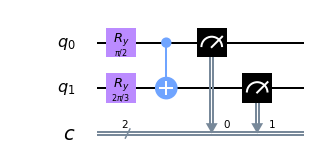

In [6]:
qo.draw(output="mpl")

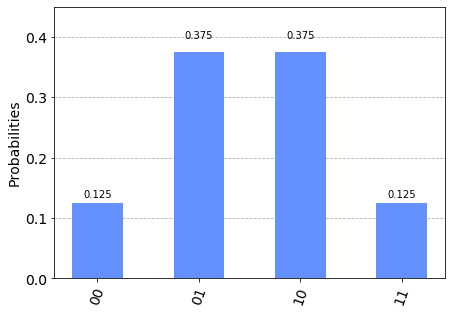

In [7]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1000000
results = execute(qo, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [8]:
exact_answer = (answer['00']*0 + answer['01']*1 + answer['10']*2**2 + answer['11']*3**2)/shots
exact_answer

2.99796

# A_operator with infinitely many shots

In [9]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(1, 'c')

cost = 0.001
qo = QuantumCircuit(q, c)

In [10]:
qo.ry(math.pi/2,q[0])
qo.ry(math.pi*2/3,q[1])
qo.cx(q[0],q[1])

qo.barrier(q[0:3])

qo.cry(4*1*np.sqrt(cost),q[0],q[2])
qo.cry(2*1*np.sqrt(cost),q[1],q[2])

qo.measure(q[2],c[0])

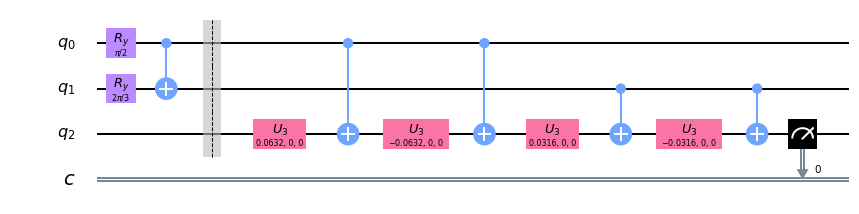

In [11]:
qo.draw(output="mpl")

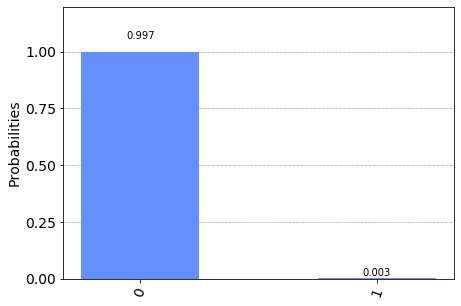

In [12]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(qo, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [13]:
probability = answer['1']/shots
Approximate_answer = probability/cost

In [14]:
print('Exact value:    \t%.4f' % exact_answer)
print('Estimated value:\t%.4f' % Approximate_answer)

Exact value:    	2.9980
Estimated value:	2.9297


# Iterative Quantum Amplitude Estimation

In [15]:
def Aoperator():
    ## A_operator
    
    qo.ry(math.pi/2,q[0])
    qo.ry(math.pi*2/3,q[1])
    qo.cx(q[0],q[1])

    qo.barrier(q[0:3])

    qo.cry(4*1*np.sqrt(cost),q[0],q[2])
    qo.cry(2*1*np.sqrt(cost),q[1],q[2])

In [16]:
def qoperator():
    ## Q_operator

    # Uf operator (constant for amplitude estimation)
    qo.barrier(q[0:3])

    qo.z(q[2])

    # A_inverse operator
    qo.cry(-2*1*np.sqrt(cost),q[1],q[2])
    qo.cry(-4*1*np.sqrt(cost),q[0],q[2])

    qo.barrier(q[0:3])

    qo.cx(q[0],q[1])
    qo.ry(-math.pi*2/3,q[1])
    qo.ry(-math.pi/2,q[0])

    # Us operator
    qo.barrier(q[0:3])

    qo.x(q[0:3])
    qo.h(q[2])
    qo.ccx(q[0],q[1],q[2])
    qo.h(q[2])
    qo.x(q[0:3])

    # A operator
    qo.barrier(q[0:3])

    qo.ry(math.pi/2,q[0])
    qo.ry(math.pi*2/3,q[1])
    qo.cx(q[0],q[1])

    qo.barrier(q[0:3])

    qo.cry(4*1*np.sqrt(cost),q[0],q[2])
    qo.cry(2*1*np.sqrt(cost),q[1],q[2])

In [17]:
def FindNextK(k,theta_l,theta_u,up):
    K = 4*k+2
    theta_min = theta_l*K
    theta_max = theta_u*K
    K_max = math.floor(math.pi/(theta_u-theta_l))
    K_largest = K_max-math.fmod((K_max-2),4) 
    k_ = 0
    
    while K_largest > 2*K:
        q = K_largest/K
        if math.fmod(q*theta_min,2*math.pi) <= math.pi and math.fmod(q*theta_max,2*math.pi) <= math.pi:
            K_ = K_largest
            up_ = 0
            k_ = (K_ - 2)/4
            break
        
        if math.fmod(q*theta_min,2*math.pi) >= math.pi and math.fmod(q*theta_max,2*math.pi) >= math.pi:
            K_ = K_largest
            up_ = 1
            k_ = (K_ - 2)/4
            break
        
        K_largest = K_largest-4
        
    if k_ > 0:
        k_ = int(k_)
        return k_,up_
    else:
        return k,up

In [131]:
## Iterative Quantum Amplitude Estimation

i = 0
k_list = ["0"]
k = 0
theta_l = 0
theta_u = math.pi/2
targetE = 0.01
shots = 2000
up = 0

T = math.ceil(math.log2(math.pi/(4*targetE)))
Num_sameiter = 1
answer_list = []
k_list = []
theta_l_list = []
theta_u_list = []
N = 1
Num_1 = 0

while abs(theta_u - theta_l) > 2*targetE:
    k_1,up = FindNextK(k,theta_l,theta_u,up)    
    k_list.append(k_1) 
    
    if k_1 == k:        
        q = QuantumRegister(3, 'q')
        c = ClassicalRegister(1, 'c')

        cost = 0.01
        qo = QuantumCircuit(q, c)
        
        Aoperator()
        
        for x in range(0, k_1):
            qoperator()
        
        qo.measure(q[2],c[0])
        
        backend = BasicAer.get_backend('qasm_simulator')
        results = execute(qo, backend=backend, shots=shots).result()
        answer = results.get_counts()
        answer_list.append(answer['1']) 
            
    elif k_1 != k:
        Num_sameiter = 1
        answer_list = []
                
        q = QuantumRegister(3, 'q')
        c = ClassicalRegister(1, 'c')

        cost = 0.01
        qo = QuantumCircuit(q, c)
        
        Aoperator()
        
        for x in range(0, k_1):
            qoperator()
        
        qo.measure(q[2],c[0])
        
        backend = BasicAer.get_backend('qasm_simulator')
        results = execute(qo, backend=backend, shots=shots).result()
        answer = results.get_counts()
        answer_list.append(answer['1']) 
    
    # calculate the CI for the constraint (less than 2L)
    for i in range(0, Num_sameiter):
        Num_1 = Num_1 + answer_list[i]
    
    probability = Num_1/((Num_sameiter)*shots)
    a_min = probability - 2.32*np.sqrt((probability*(1-probability))/((Num_sameiter)*shots))
    a_max = probability + 2.32*np.sqrt((probability*(1-probability))/((Num_sameiter)*shots))
    
    Num_sameiter = Num_sameiter + 1
    
    k = k_1
    K = 4*k + 2

    TMIN = (np.arccos(1-2*a_min)) 
    if up == 1:
        theta_u = (math.floor((K*theta_l)/(2*np.pi))*(2*np.pi)+(2*np.pi-TMIN))/K
    elif up == 0:
        theta_l = (math.floor((K*theta_l)/(2*np.pi))*(2*np.pi)+TMIN)/K
        
    TMAX = (np.arccos(1-2*a_max))
    if up == 1:
        theta_l = (math.floor((K*theta_u)/(2*np.pi))*(2*np.pi)+(2*np.pi-TMAX))/K
    elif up == 0:
        theta_u = (math.floor((K*theta_u)/(2*np.pi))*(2*np.pi)+TMAX)/K
        
    theta_l_list.append(theta_l) 
    theta_u_list.append(theta_u) 
    A_l = np.sin(theta_l)**2/cost
    A_u = np.sin(theta_u)**2/cost
    
    N = N+1

N_measure = (N-1)*shots
Mean = (A_l+A_u)/2

In [132]:
print('theta_lower:         \t%.4f' % theta_l)
print('theta_upper:         \t%.4f' % theta_u)
print('lower CI for E(x^2):  \t%.4f' % A_l)
print('upper CI for E(x^2):  \t%.4f' % A_u)
print('Mean for E(x^2):  \t%.4f' % Mean)
print('Number of measurement:\t%.4f' % N_measure)

theta_lower:         	0.1733
theta_upper:         	0.1755
lower CI for E(x^2):  	2.9721
upper CI for E(x^2):  	3.0492
Mean for E(x^2):  	3.0106
Number of measurement:	4000.0000
